In this example notebook, we look at the case of a bivariate spatial random field where the two variates are observed on non-overlapping sets of locations.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from debiased_spatial_whittle.backend import BackendManager

BackendManager.set_backend("numpy")

from debiased_spatial_whittle.models.univariate import SquaredExponentialModel
from debiased_spatial_whittle.models.bivariate import BivariateUniformCorrelation
from debiased_spatial_whittle.inference.multivariate_periodogram import Periodogram
from debiased_spatial_whittle.inference.periodogram import ExpectedPeriodogram
from debiased_spatial_whittle.inference.likelihood import MultivariateDebiasedWhittle, Estimator
from debiased_spatial_whittle.grids.base import RectangularGrid
from debiased_spatial_whittle.sampling.simulation import SamplerBUCOnRectangularGrid

## Grid specification

In [2]:
g = RectangularGrid((256, 256), nvars=2)
g.mask = np.random.rand(*g.mask.shape) > 0.2
x, y = g.grid_points
g.mask[..., 0] = np.mod(x, 40) <= 20
g.mask[..., 1] = np.mod(x, 40) > 20

## Model definition

In [3]:
m = SquaredExponentialModel()
m.rho = 12
m.sigma = 1
m.nugget = 0.01
bvm = BivariateUniformCorrelation(m)
bvm.r = 0.75
bvm.f = 2.0
bvm

Name,Value,Type,Range
f,2.0,ModelParameter,"(0, inf)"
r,0.75,ModelParameter,"(-1, 1)"
Name,Value,Type,Range
rho,12,ModelParameter,"(0, inf)"
sigma,1,ModelParameter,"(0, inf)"


## Sample generation

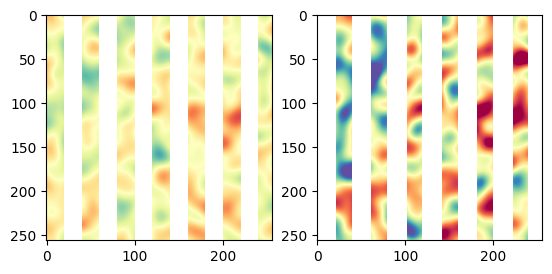

In [4]:
s = SamplerBUCOnRectangularGrid(bvm, g)

data = s()
data_plot = np.where(g.mask != 0, data, np.nan)

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(data_plot[..., 0], cmap="Spectral_r", vmin=-4, vmax=4)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(data_plot[..., 1], cmap="Spectral_r", vmin=-4, vmax=4)
plt.show();

## Profile likelihood plot of correlation coefficient

In [5]:
p = Periodogram()
p.fold = True

ep = ExpectedPeriodogram(g, p)
db = MultivariateDebiasedWhittle(p, ep)

In [6]:
%timeit db(data, bvm)

ValueError: Input array needs to be 2D but received a 4d-array.

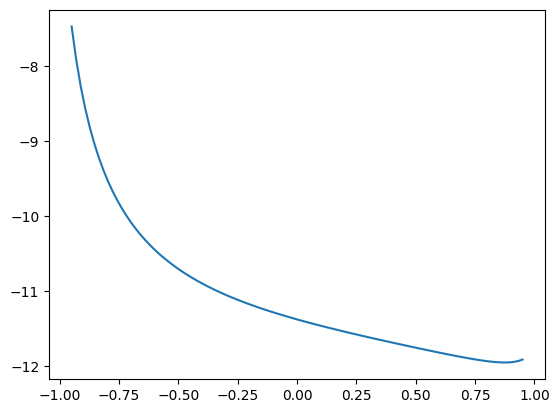

In [9]:
p = Periodogram()
p.fold = True

ep = ExpectedPeriodogram(g, p)
db = MultivariateDebiasedWhittle(p, ep)

rs = np.linspace(-0.95, 0.95, 100)
lkhs = np.zeros_like(rs)

for i, r in enumerate(rs):
    bvm.r = r
    lkhs[i] = db(data, bvm)

plt.figure()
plt.plot(rs, lkhs, "-")
plt.show()

## Inference

In [11]:
estimator = Estimator(db)
bvm.r = 0.0
bvm.f = 1.0
m.rho = 1.0
m.sigma = 1.0

In [12]:
from IPython import display


def func(*args, **kargs):
    display.clear_output(wait=True)
    display.display(bvm)


estimate = estimator(bvm, data, opt_callback=func)

Name,Value,Type,Range
f,2.0335404150373173,ModelParameter,"(0, inf)"
r,0.8278997107580713,ModelParameter,"(-1, 1)"
Name,Value,Type,Range
rho,13.996443593288996,ModelParameter,"(0, inf)"
sigma,1.4641011480173776,ModelParameter,"(0, inf)"
